## Setup

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [26]:
data_dir = 'C:/Users/finno/Workspace/adapt-patient-tracker/testing_logs/'
logs_dir = 'D:/bme/labels/validation/'

In [99]:
def load_data_from_prefix(prefix):
    logs_df = pd.DataFrame()
    for filename in os.listdir(data_dir):
        if filename.endswith(".bag") and filename.startswith(prefix): 
            file_path = os.path.join(data_dir, filename)
            
            current_df = pd.read_csv(file_path, skiprows=1, header=None, names=['t', 'UI', 'init', 'd', 'a', 'fps', 'b1', 'b2', 'b3', 'b4', 'len_conf'])
            
            s = (filename[:-4].split('_'))
            current_df['date'] = s[2] + '_' + s[3]
            current_df['param'] = s[1]
            try:
                current_df['q'] = int(s[1][1:])
            except:
                current_df['q'] = s[1][1:] 
            
            logs_df = logs_df.append(current_df, ignore_index=True)

    return logs_df


In [100]:
def load_labels():
    labels_df = pd.DataFrame()

    for filename in os.listdir(logs_dir):
        if filename.endswith(".txt"): 
            file_path = os.path.join(logs_dir, filename)
            
            current_df = pd.read_csv(file_path, skiprows=1, header=None, names=['t', 'x', 'y', 'd'])
            current_df['date'] = filename[6:-4]
            
            labels_df = labels_df.append(current_df, ignore_index=True)
    labels_df['t'] = pd.to_numeric(labels_df['t'], errors='coerce')
    labels_df['x'] = pd.to_numeric(labels_df['x'], errors='coerce')
    labels_df['y'] = pd.to_numeric(labels_df['y'], errors='coerce')
    labels_df['d'] = pd.to_numeric(labels_df['d'], errors='coerce')

    return labels_df


## 1. Queue Length Investigation

In [101]:
# Load labels
labels_df = load_labels()

q10_df = load_data_from_prefix('A01_q10_')
q20_df = load_data_from_prefix('A01_default_')
q20_df['q'] = 20
q40_df = load_data_from_prefix('A01_q40_')
q80_df = load_data_from_prefix('A01_q80_')
q160_df = load_data_from_prefix('A01_q160_')

C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = 

In [102]:
# Merge all dataframes together
q_df = pd.concat([q10_df, q20_df, q40_df, q80_df, q160_df])
q_df['x'] = (q_df['b1'].apply(lambda x: int(x) if (str(x) != 'None') else None) + q_df['b3'].apply(lambda x: int(x) if (str(x) != 'None') else None))/2

# Filter labels for ones in q_df
labels_df = labels_df[labels_df.date.isin(q_df.date)]

# Ensure all trials are accounted for
assert len(labels_df.date.unique()) == len(q_df.date.unique())

# Transfer interpolated x signal
labels_int = interp1d(labels_df['t'], labels_df['x'], kind='linear', fill_value='extrapolate')
q_df['label_x'] = labels_int(q_df['t'])

# Calculate error signals
ERR_THRESH = 50
q_df['abs_diff'] = np.abs(q_df['label_x'] - q_df['x'])
q_df['correct'] = q_df['abs_diff'] < ERR_THRESH

In [103]:
# Aggregate per q

filt = q_df[q_df['init']==0]
res = filt.groupby('q').mean().reset_index()

C:\Users\finno\AppData\Local\Temp\ipykernel_33228\4185809974.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res = filt.groupby('q').mean().reset_index()


Text(0.5, 1.0, 'Investigation of Queue Length Accuracy')

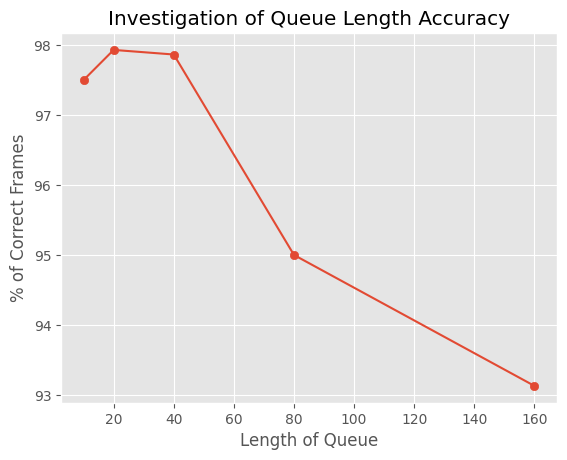

In [104]:
# Plot performance

plt.style.use('ggplot')
plt.plot(res['q'], res['correct']*100)
plt.scatter(res['q'], res['correct']*100)
plt.xlabel('Length of Queue')
plt.ylabel('% of Correct Frames')
plt.title('Investigation of Queue Length Accuracy')


Text(0.5, 1.0, 'Investigation of Queue Length Frame Rate')

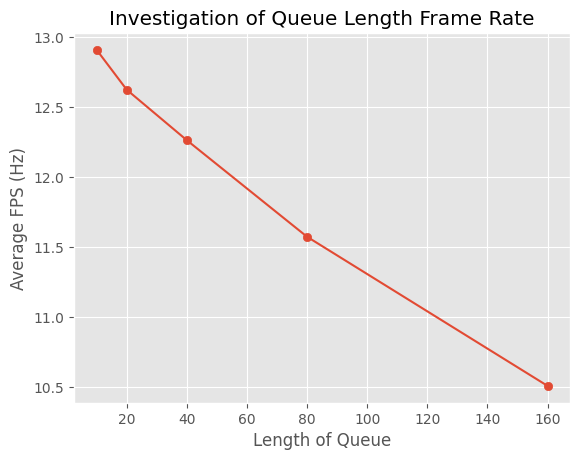

In [105]:
# Plot

plt.style.use('ggplot')
plt.plot(res['q'], res['fps'])
plt.scatter(res['q'], res['fps'])
plt.xlabel('Length of Queue')
plt.ylabel('Average FPS (Hz)')
plt.title('Investigation of Queue Length Frame Rate')


## 2. Queue Density Investigation

In [106]:
# Load labels
labels_df = load_labels()

d1_df = load_data_from_prefix('A01_default_')
d1_df['f'] = 4

d2_df = load_data_from_prefix('A01_d8hz')
d2_df['f'] = 8

d3_df = load_data_from_prefix('A01_d16hz')
d3_df['f'] = 16

d4_df = load_data_from_prefix('A01_dhalf_')
d4_df['f'] = 2

d5_df = load_data_from_prefix('A01_done_')
d5_df['f'] = 1

C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = 

In [109]:
# Merge all dataframes together
d_df = pd.concat([d1_df, d2_df, d3_df, d4_df, d5_df])
d_df['x'] = (d_df['b1'].apply(lambda x: int(x) if (str(x) != 'None') else None) + d_df['b3'].apply(lambda x: int(x) if (str(x) != 'None') else None))/2

# Filter labels for ones in d_df
labels_df = labels_df[labels_df.date.isin(d_df.date)]

# Ensure all trials are accounted for
assert len(labels_df.date.unique()) == len(d_df.date.unique())

# Transfer interpolated x signal
labels_int = interp1d(labels_df['t'], labels_df['x'], kind='linear', fill_value='extrapolate')
d_df['label_x'] = labels_int(d_df['t'])

# Calculate error signals
ERR_THRESH = 50
d_df['abs_diff'] = np.abs(d_df['label_x'] - d_df['x'])
d_df['correct'] = d_df['abs_diff'] < ERR_THRESH

In [110]:
# Aggregate per f

filt = d_df[d_df['init']==0]
res = filt.groupby('f').mean().reset_index()

C:\Users\finno\AppData\Local\Temp\ipykernel_33228\4187085578.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res = filt.groupby('f').mean().reset_index()


Text(0.5, 1.0, 'Investigation of Queue Density Accuracy')

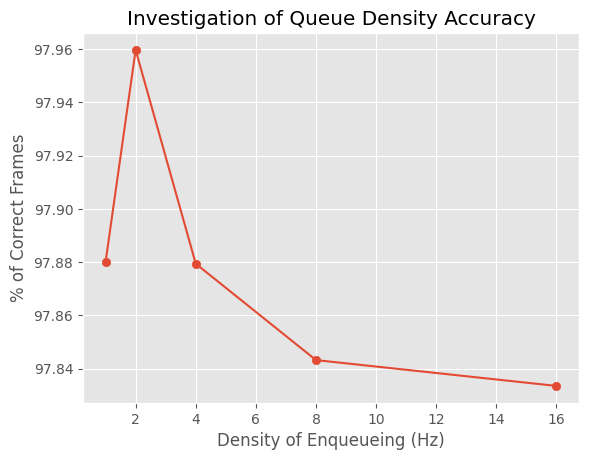

In [111]:
# Plot performance

plt.style.use('ggplot')
plt.plot(res['f'], res['correct']*100)
plt.scatter(res['f'], res['correct']*100)
plt.xlabel('Density of Enqueueing (Hz)')
plt.ylabel('% of Correct Frames')
plt.title('Investigation of Queue Density Accuracy')


Text(0.5, 1.0, 'Investigation of Queue Density Frame Rate')

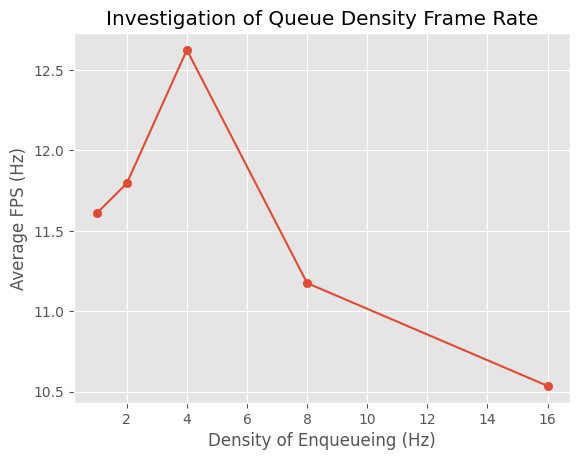

In [113]:
# Plot

plt.style.use('ggplot')
plt.plot(res['f'], res['fps'])
plt.scatter(res['f'], res['fps'])
plt.xlabel('Density of Enqueueing (Hz)')
plt.ylabel('Average FPS (Hz)')
plt.title('Investigation of Queue Density Frame Rate')


## 3. Number of Orb Features Investigation

In [119]:
# Load labels
labels_df = load_labels()

d1_df = load_data_from_prefix('A01_default_')
d1_df['orb'] = 500

d2_df = load_data_from_prefix('A01_orb10_')
d2_df['orb'] = 10

d3_df = load_data_from_prefix('A01_orb50_')
d3_df['orb'] = 50

d4_df = load_data_from_prefix('A01_orb100_')
d4_df['orb'] = 100

d5_df = load_data_from_prefix('A01_orb1000_')
d5_df['orb'] = 1000

d6_df = load_data_from_prefix('A01_orb5000_')
d6_df['orb'] = 5000

C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = labels_df.append(current_df, ignore_index=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33228\844476130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels_df = 

In [120]:
# Merge all dataframes together
d_df = pd.concat([d1_df, d2_df, d3_df, d4_df, d5_df, d6_df])
d_df['x'] = (d_df['b1'].apply(lambda x: int(x) if (str(x) != 'None') else None) + d_df['b3'].apply(lambda x: int(x) if (str(x) != 'None') else None))/2

# Filter labels for ones in d_df
labels_df = labels_df[labels_df.date.isin(d_df.date)]

# Ensure all trials are accounted for
assert len(labels_df.date.unique()) == len(d_df.date.unique())

# Transfer interpolated x signal
labels_int = interp1d(labels_df['t'], labels_df['x'], kind='linear', fill_value='extrapolate')
d_df['label_x'] = labels_int(d_df['t'])

# Calculate error signals
ERR_THRESH = 50
d_df['abs_diff'] = np.abs(d_df['label_x'] - d_df['x'])
d_df['correct'] = d_df['abs_diff'] < ERR_THRESH

In [122]:
# Aggregate per f

filt = d_df[d_df['init']==0]
res = filt.groupby('orb').mean().reset_index()

C:\Users\finno\AppData\Local\Temp\ipykernel_33228\3059760648.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res = filt.groupby('orb').mean().reset_index()


Text(0.5, 1.0, 'Investigation of ORB Features')

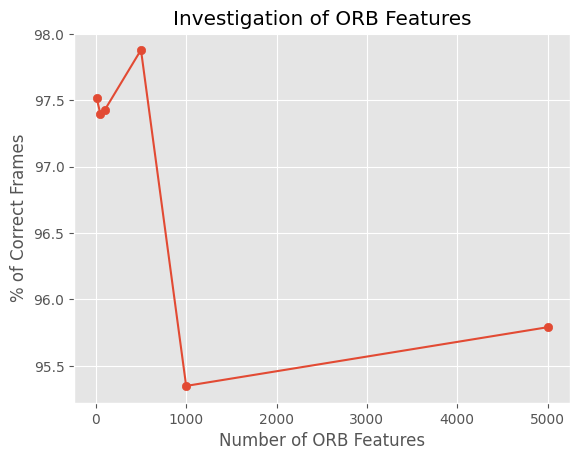

In [123]:
# Plot performance

plt.style.use('ggplot')
plt.plot(res['orb'], res['correct']*100)
plt.scatter(res['orb'], res['correct']*100)
plt.xlabel('Number of ORB Features')
plt.ylabel('% of Correct Frames')
plt.title('Investigation of ORB Features Accuracy')


Text(0.5, 1.0, 'Investigation of ORB Features Frame Rate')

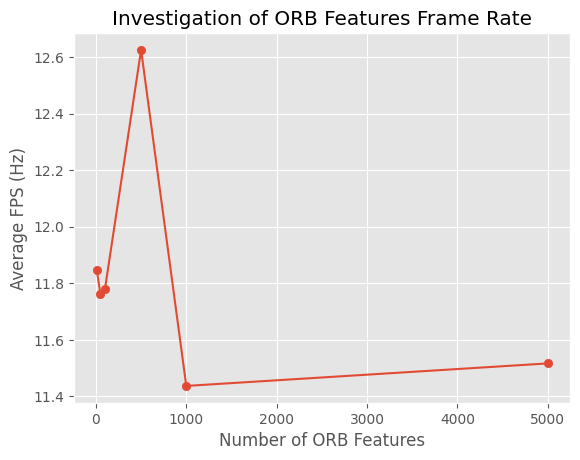

In [124]:
# Plot

plt.style.use('ggplot')
plt.plot(res['orb'], res['fps'])
plt.scatter(res['orb'], res['fps'])
plt.xlabel('Number of ORB Features')
plt.ylabel('Average FPS (Hz)')
plt.title('Investigation of ORB Features Frame Rate')


## Distance Investigation

In [ ]:
# Load labels
labels_df = load_labels()

d1_df = load_data_from_prefix('A01_cheby_')
d1_df['dist'] = 'Chebyshev'

d2_df = load_data_from_prefix('A01_cosine_')
d2_df['dist'] = 'Cosine'

d3_df = load_data_from_prefix('A01_euclid_')
d3_df['dist'] = 'Euclid'

d4_df = load_data_from_prefix('A01_default_')
d4_df['dist'] = 'Manhattan'

In [126]:
d4_df

,t,UI,init,d,a,fps,b1,b2,b3,b4,len_conf,date,param,q,dist
0,1.707583e+12,1,1,None,None,0.000000,None,None,None,None,1,20240210_113406,default,efault,Manhattan
1,1.707583e+12,1,1,None,None,4.710420,None,None,None,None,1,20240210_113406,default,efault,Manhattan
2,1.707583e+12,1,1,None,None,8.386049,None,None,None,None,1,20240210_113406,default,efault,Manhattan
3,1.707583e+12,1,1,None,None,10.322288,None,None,None,None,1,20240210_113406,default,efault,Manhattan
4,1.707583e+12,1,1,None,None,11.346740,None,None,None,None,1,20240210_113406,default,efault,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,1.710704e+12,1,0,0.9500000451225787,17.85,15.756490,240,317,464,478,3,20240317_153332,default,efault,Manhattan
5034,1.710704e+12,1,1,None,None,14.827727,None,None,None,None,2,20240317_153332,default,efault,Manhattan
5035,1.710704e+12,1,1,None,None,17.344454,None,None,None,None,2,20240317_153332,default,efault,Manhattan
5036,1.710704e+12,1,1,None,None,18.415048,None,None,None,None,2,20240317_153332,default,efault,Manhattan


In [131]:
# Merge all dataframes together
d_df = pd.concat([d1_df, d2_df, d3_df, d4_df])
d_df['x'] = (d_df['b1'].apply(lambda x: int(x) if (str(x) != 'None') else None) + d_df['b3'].apply(lambda x: int(x) if (str(x) != 'None') else None))/2

# Filter labels for ones in d_df
labels_df = labels_df[labels_df.date.isin(d_df.date)]

# Ensure all trials are accounted for
assert len(labels_df.date.unique()) == len(d_df.date.unique())

# Transfer interpolated x signal
labels_int = interp1d(labels_df['t'], labels_df['x'], kind='linear', fill_value='extrapolate')
d_df['label_x'] = labels_int(d_df['t'])

# Calculate error signals
ERR_THRESH = 50
d_df['abs_diff'] = np.abs(d_df['label_x'] - d_df['x'])
d_df['correct'] = d_df['abs_diff'] < ERR_THRESH

In [132]:
# Aggregate per f

filt = d_df[d_df['init']==0]
res = filt.groupby('dist').mean().reset_index()

C:\Users\finno\AppData\Local\Temp\ipykernel_33228\4140060307.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res = filt.groupby('dist').mean().reset_index()


Text(0.5, 1.0, 'Investigation of Distance Metric Accuracy')

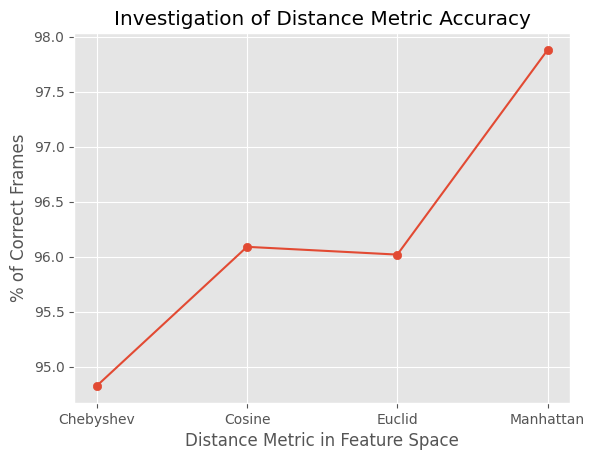

In [134]:
# Plot performance

plt.style.use('ggplot')
plt.plot(res['dist'], res['correct']*100)
plt.scatter(res['dist'], res['correct']*100)
plt.xlabel('Distance Metric in Feature Space')
plt.ylabel('% of Correct Frames')
plt.title('Investigation of Distance Metric Accuracy')


Text(0.5, 1.0, 'Investigation of Distance Metric Frame Rate')

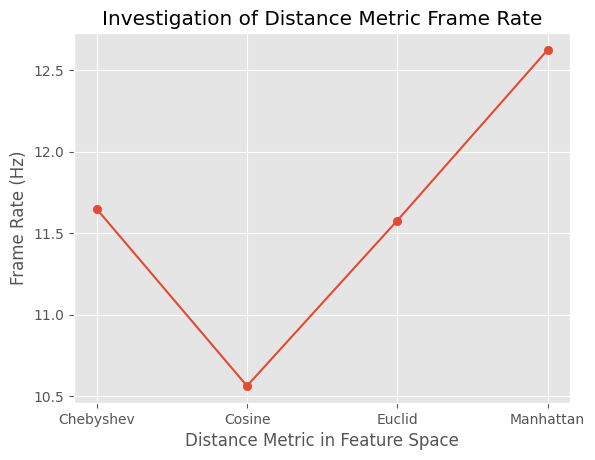

In [136]:
# Plot fps

plt.style.use('ggplot')
plt.plot(res['dist'], res['fps'])
plt.scatter(res['dist'], res['fps'])
plt.xlabel('Distance Metric in Feature Space')
plt.ylabel('Frame Rate (Hz)')
plt.title('Investigation of Distance Metric Frame Rate')
